In [1]:
import os
import shutil
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split

with tf.device('/CPU:0'):
    
    validation_files = tf.io.gfile.glob('../../opt/datasets/chest_xray/chest_xray/val/*/*')
    train_data = ImageDataGenerator(rescale=1./255,validation_split=0.2)
    test_data = ImageDataGenerator(rescale=1./255)

    normal_data_dir = '../../opt/datasets/chest_xray/chest_xray/train/'
    validation_data_dir = '../../opt/datasets/chest_xray/chest_xray/val/'

    train_gen = train_data.flow_from_directory(normal_data_dir,target_size=(150,150),batch_size=20,class_mode='binary',subset="training") 
    val_gen = train_data.flow_from_directory(normal_data_dir,target_size=(150,150),batch_size=20,class_mode='binary',subset="validation")    

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [5]:
files = tf.io.gfile.glob('../opt/datasets/chest_xray/chest_xray/train/*/*')
normal_cases = len([fname for fname in files if 'NORMAL' in fname])
pneumonia_cases = len([fname for fname in files if 'PNEUMONIA' in fname])
print('NORMAL PNEUMONIA:',normal_cases,pneumonia_cases)

NORMAL PNEUMONIA: 1349 3883


In [4]:
for elem,label in train_gen:
    print(elem.shape)
    break

(20, 150, 150, 3)


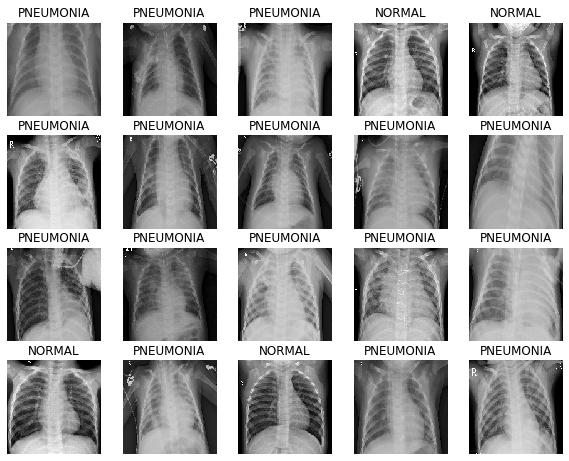

In [57]:
import matplotlib.pyplot as plt

with tf.device('/CPU:0'):
    plt.figure(figsize=(10,10))
    img,label = train_gen.next()
    index = 0
    for image in img:
        horizontal = plt.subplot(5,5,index+1)
        plt.imshow(img[index])
        plt.axis('off')
        plt.title('PNEUMONIA' if label[index]==1 else 'NORMAL')
        index +=1
    

In [58]:
from tensorflow.keras import layers
from tensorflow.keras import models

with tf.device('/CPU:0'):

    my_model = models.Sequential()
    my_model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
    my_model.add(layers.MaxPooling2D((2,2)))
    my_model.add(layers.Conv2D(64,(3,3),activation="relu"))
    #my_model.add(layers.MaxPooling2D((2,2)))
    #my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
    #my_model.add(layers.MaxPooling2D((2,2)))
    #my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
    my_model.add(layers.MaxPooling2D((2,2)))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dropout(0.5))
    my_model.add(layers.Dense(128,activation="relu"))
    my_model.add(layers.Dense(1,activation='sigmoid'))
    my_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 82944)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [59]:
from tensorflow.keras import optimizers

with tf.device('/GPU:0'):
    METRICS = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    my_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
    
    history=my_model.fit(
            train_gen,
            steps_per_epoch=200,
            epochs=60,
            validation_data=val_gen,
            validation_steps=50
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 200 steps, validate for 50 steps
Epoch 1/60
200/200 [==============================] - 30s 148ms/step - loss: 0.2024 - accuracy: 0.9268 - precision: 0.9389 - recall: 0.9637 - val_loss: 0.1430 - val_accuracy: 0.9410 - val_precision: 0.9490 - val_recall: 0.9732
Epoch 2/60
200/200 [==============================] - 29s 145ms/step - loss: 0.1007 - accuracy: 0.9666 - precision: 0.9774 - recall: 0.9777 - val_loss: 0.1158 - val_accuracy: 0.9590 - val_precision: 0.9681 - val_recall: 0.9772
Epoch 3/60
200/200 [==============================] - 29s 146ms/step - loss: 0.0872 - accuracy: 0.9691 - precision: 0.9790 - recall: 0.9793 - val_loss: 0.1217 - val_accuracy: 0.9550 - val_precision: 0.9834 - val_recall: 0.9558
Epoch 4/60
200/200 [==============================] - 29s 146ms/step - loss: 0.0645 - accuracy: 0.9762 - precision: 0.9858 - recall: 0.9821 - val_loss: 0.1270 - val_accuracy: 0.9530 - val_precision: 0.9464 - val_recall: 0.9933

200/200 [==============================] - 29s 145ms/step - loss: 4.2820e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1775 - val_accuracy: 0.9630 - val_precision: 0.9797 - val_recall: 0.9705
Epoch 37/60
200/200 [==============================] - 29s 145ms/step - loss: 6.2115e-04 - accuracy: 0.9997 - precision: 1.0000 - recall: 0.9997 - val_loss: 0.1870 - val_accuracy: 0.9650 - val_precision: 0.9772 - val_recall: 0.9759
Epoch 38/60
200/200 [==============================] - 29s 146ms/step - loss: 7.1696e-04 - accuracy: 0.9997 - precision: 0.9997 - recall: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9660 - val_precision: 0.9772 - val_recall: 0.9772
Epoch 39/60
200/200 [==============================] - 29s 145ms/step - loss: 0.0077 - accuracy: 0.9975 - precision: 0.9983 - recall: 0.9983 - val_loss: 0.1596 - val_accuracy: 0.9620 - val_precision: 0.9758 - val_recall: 0.9732
Epoch 40/60
200/200 [==============================] - 29s 145ms/step - loss: 0.0018 - a

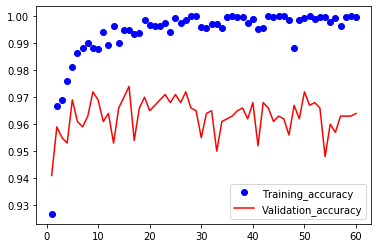

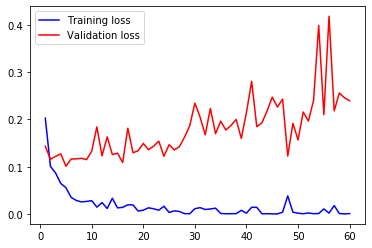

In [61]:
import matplotlib.pyplot as plt

# dataset is highly unbalanced
# there are too few validation data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training_accuracy')
plt.plot(epochs,val_accuracy,'r',label='Validation_accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.legend()
plt.show()

In [62]:
test_gen = test_data.flow_from_directory('/opt/datasets/chest_xray/test/',target_size=(150,150),batch_size=20,class_mode='binary')

results = my_model.evaluate(test_gen)

Found 624 images belonging to 2 classes.
  ...
    to  
  ['...']
32/32 [==============================] - 3s 87ms/step - loss: 4.7564 - accuracy: 0.7436 - precision: 0.7114 - recall: 0.9923


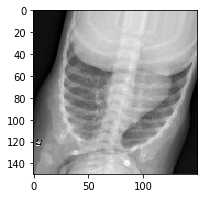

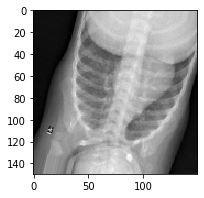

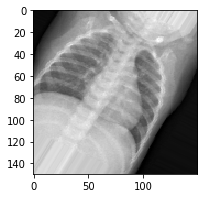

In [59]:
# PERFORMING DATA ARGUMENTATION 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

data_arg = ImageDataGenerator(rescale=1/255.,rotation_range=30,width_shift_range=0.1,# traslazione verticale
    height_shift_range=0.1,# traslazione orizontale
    #shear_range=0.1,# taglio
    zoom_range=0.1,#zoommare
    vertical_flip=True,
    #horizontal_flip=True,#flippo l'immagine orizontalmente
    fill_mode='nearest',#come riempire i pixel dopo traslazione e shift
    validation_split=0.2
) 

fnames = [ os.path.join('/opt/datasets/chest_xray/train/NORMAL',fname) for fname in os.listdir('/opt/datasets/chest_xray/train/NORMAL')  ]

image_path= fnames[3]

img = tf.keras.preprocessing.image.load_img(image_path,target_size=(150,150))

x = tf.keras.preprocessing.image.img_to_array(img)
x = x.reshape((1,) + x.shape )# adding a dimension

index = 0

for batch in data_arg.flow(x,batch_size=1):
    plt.figure(figsize=(10,10))
    horizontal = plt.subplot(1,3,index+1)
    imgplot=plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
    index = index+1
    if index%3==0:
        break


In [60]:
from tensorflow.keras import layers
from tensorflow.keras import models

with tf.device('/CPU:0'):
    train_gen = data_arg.flow_from_directory(normal_data_dir,target_size=(150,150),batch_size=20,class_mode='binary',shuffle=True,subset="training") 
    val_gen = data_arg.flow_from_directory(normal_data_dir,target_size=(150,150),batch_size=20,class_mode='binary',shuffle=True,subset="validation")    
    
    my_model = models.Sequential()
    my_model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
    my_model.add(layers.MaxPooling2D((2,2)))
    my_model.add(layers.Conv2D(64,(3,3),activation="relu"))
    #my_model.add(layers.MaxPooling2D((2,2)))
    #my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
    my_model.add(layers.MaxPooling2D((2,2)))
    my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
    my_model.add(layers.MaxPooling2D((2,2)))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dropout(0.5))
    my_model.add(layers.Dense(128,activation="relu"))
    my_model.add(layers.Dense(1,activation='sigmoid'))
    my_model.summary()


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 128)       0         
____________________________________

In [61]:
from tensorflow.keras import optimizers

with tf.device('/GPU:0'):
    METRICS = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    
    my_model.compile(loss='binary_crossentropy',optimizer='adam',metrics = METRICS)
    
    history=my_model.fit(
            train_gen,
            steps_per_epoch=200,
            epochs=25,
            validation_data=val_gen,
            validation_steps=50
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 39s 193ms/step - loss: 0.5323 - accuracy: 0.7577 - precision: 0.7861 - recall: 0.9261 - val_loss: 0.3473 - val_accuracy: 0.8300 - val_precision: 0.9469 - val_recall: 0.8167
Epoch 2/25
200/200 [==============================] - 38s 192ms/step - loss: 0.3092 - accuracy: 0.8580 - precision: 0.9027 - recall: 0.9058 - val_loss: 0.2734 - val_accuracy: 0.8790 - val_precision: 0.9113 - val_recall: 0.9272
Epoch 3/25
200/200 [==============================] - 38s 191ms/step - loss: 0.2698 - accuracy: 0.8851 - precision: 0.9219 - recall: 0.9237 - val_loss: 0.2615 - val_accuracy: 0.8780 - val_precision: 0.8865 - val_recall: 0.9582
Epoch 4/25
200/200 [==============================] - 38s 191ms/step - loss: 0.2498 - accuracy: 0.8954 - precision: 0.9266 - recall: 0.9326 - val_loss: 0.3527 - val_accuracy: 0.8380 - val_precision: 0.9882 - val_recall: 0.7911

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


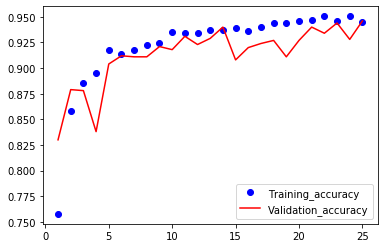

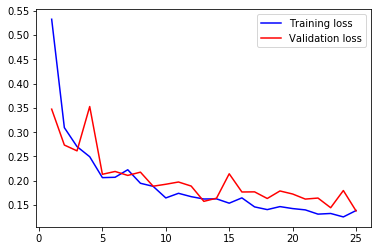

In [62]:
import matplotlib.pyplot as plt

# dataset is highly unbalanced
# there are too few validation data
print(history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training_accuracy')
plt.plot(epochs,val_accuracy,'r',label='Validation_accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.legend()
plt.show()

In [63]:
test_gen = test_data.flow_from_directory('/opt/datasets/chest_xray/test/',target_size=(150,150),batch_size=32,shuffle=True,class_mode='binary')

results = my_model.evaluate(test_gen)

Found 624 images belonging to 2 classes.
  ...
    to  
  ['...']
20/20 [==============================] - 3s 138ms/step - loss: 0.5965 - accuracy: 0.8157 - precision: 0.7734 - recall: 0.9974


In [64]:
my_model.save('Data_argumented.h5')

[[0.44442636]]


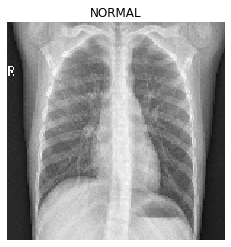

In [24]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

data_argumentes = load_model('./Data_argumented.h5')

fnames = [ os.path.join('../../opt/datasets/chest_xray/chest_xray/test/NORMAL/',fname) for fname in os.listdir('../../opt/datasets/chest_xray/chest_xray/test/NORMAL/')  ]
image_path= fnames[1]

img = tf.keras.preprocessing.image.load_img(image_path,target_size=(150,150))
plt.figure(figsize=(4,4))
plt.axis('off')
plt.title('NORMAL')
plt.imshow(img)

rescaler=ImageDataGenerator(rescale=1./255)
x = tf.keras.preprocessing.image.img_to_array(img)
x = x.reshape((1,) + x.shape )# adding a dimension

res=data_argumentes.predict(rescaler.flow(x))
print(res)

In [65]:
# Downsampling
normal_cases = tf.io.gfile.glob('../opt/datasets/chest_xray/chest_xray/train/NORMAL/*')
print(len(normal_cases))
pneumoina_cases = tf.io.gfile.glob('../opt/datasets/chest_xray/chest_xray/train/PNEUMONIA/*')
pneumoina_cases = pneumoina_cases[:1349] 
print(len(pneumoina_cases))

1349
1349


In [13]:
import shutil

normal_dst = '../opt/datasets/chest_xray/small_data/downsample/train_downsample/NORMAL/'
pneumonia_dst = '../opt/datasets/chest_xray/small_data/downsample/train_downsample/PNEUMONIA/'

for index in range(len(normal_cases)):
    shutil.copy(normal_cases[index], normal_dst)
    shutil.copy(pneumoina_cases[index],pneumonia_dst)

In [66]:
train_data = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_data = ImageDataGenerator(rescale=1./255)

normal_data_dir = '../opt/datasets/chest_xray/small_data/downsample/train_downsample/'

train_gen = train_data.flow_from_directory(normal_data_dir,target_size=(150,150),batch_size=20,class_mode='binary',subset="training",shuffle=False) 
val_gen = train_data.flow_from_directory(normal_data_dir,target_size=(150,150),batch_size=20,class_mode='binary',subset="validation",shuffle=False)    

Found 2160 images belonging to 2 classes.
Found 538 images belonging to 2 classes.


In [67]:
from tensorflow.keras import layers
from tensorflow.keras import models

my_model = models.Sequential()
my_model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
my_model.add(layers.MaxPooling2D((2,2)))
my_model.add(layers.Conv2D(64,(3,3),activation="relu"))
    #my_model.add(layers.MaxPooling2D((2,2)))
    #my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
my_model.add(layers.MaxPooling2D((2,2)))
my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
my_model.add(layers.MaxPooling2D((2,2)))
my_model.add(layers.Flatten())
my_model.add(layers.Dropout(0.5))
my_model.add(layers.Dense(128,activation="relu"))
my_model.add(layers.Dense(1,activation='sigmoid'))
my_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 36992)            

In [68]:
from tensorflow.keras import optimizers

with tf.device('/GPU:0'):
    METRICS = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    
    my_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
    
    history=my_model.fit(
            train_gen,
            steps_per_epoch=100,
            epochs=25,
            validation_data=val_gen,
            validation_steps=26
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 26 steps
Epoch 1/25
100/100 [==============================] - 20s 204ms/step - loss: 0.9901 - accuracy: 0.5335 - precision: 0.5262 - recall: 0.8578 - val_loss: 0.6606 - val_accuracy: 0.5058 - val_precision: 0.4940 - val_recall: 0.9761
Epoch 2/25
100/100 [==============================] - 20s 200ms/step - loss: 0.5046 - accuracy: 0.8155 - precision: 0.8058 - recall: 0.8500 - val_loss: 0.3222 - val_accuracy: 0.8885 - val_precision: 0.8726 - val_recall: 0.9004
Epoch 3/25
100/100 [==============================] - 20s 203ms/step - loss: 0.3392 - accuracy: 0.8795 - precision: 0.8813 - recall: 0.8714 - val_loss: 0.4058 - val_accuracy: 0.8212 - val_precision: 0.8038 - val_recall: 0.8327
Epoch 4/25
100/100 [==============================] - 20s 201ms/step - loss: 0.3246 - accuracy: 0.8920 - precision: 0.9066 - recall: 0.8740 - val_loss: 0.3018 - val_accuracy: 0.8942 - val_precision: 0.8577 - val_recall: 0.9363

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


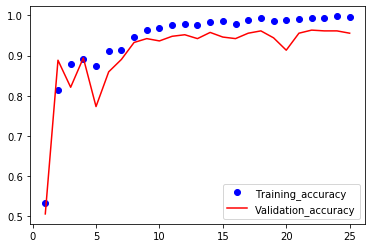

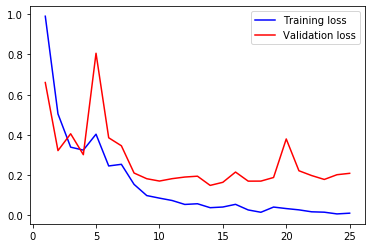

In [69]:
import matplotlib.pyplot as plt

# dataset is highly unbalanced
# there are too few validation data
print(history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training_accuracy')
plt.plot(epochs,val_accuracy,'r',label='Validation_accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.legend()
plt.show()

In [70]:
test_gen = test_data.flow_from_directory('/opt/datasets/chest_xray/test/',target_size=(150,150),batch_size=32,class_mode='binary')

results = my_model.evaluate(test_gen)

Found 624 images belonging to 2 classes.
  ...
    to  
  ['...']
20/20 [==============================] - 3s 140ms/step - loss: 1.1142 - accuracy: 0.7997 - precision: 0.7634 - recall: 0.9846


In [36]:
# Performing data argumentation with balanced dataset only on train
normal_cases = tf.io.gfile.glob('../opt/datasets/chest_xray/small_data/downsample/train_downsample/NORMAL/*')
pneumonia_cases = tf.io.gfile.glob('../opt/datasets/chest_xray/small_data/downsample/train_downsample/PNEUMONIA/*')

validation_normal = normal_cases[:269]
validation_pneumonia = pneumonia_cases[:269]
normal_cases = normal_cases[269:]
pneumonia_cases = pneumonia_cases[269:]
print(len(pneumonia_cases),len(normal_cases))

1080 1080


In [37]:
import shutil

normal_val_dst = '../opt/datasets/chest_xray/small_data/balanced/validation_balanced/NORMAL/'
pneumonia_val_dst = '../opt/datasets/chest_xray/small_data/balanced/validation_balanced/PNEUMONIA/'

normal_train_dst = '../opt/datasets/chest_xray/small_data/balanced/train_balanced/NORMAL/'
pneumonia_train_dst = '../opt/datasets/chest_xray/small_data/balanced/train_balanced/PNEUMONIA/'

for index in range(len(validation_normal)):
    shutil.copy(validation_normal[index], normal_val_dst)
    shutil.copy(validation_pneumonia[index],pneumonia_val_dst)

for index in range(len(normal_cases)):
    shutil.copy(normal_cases[index], normal_train_dst)
    shutil.copy(pneumonia_cases[index],pneumonia_train_dst)

In [42]:
train_dir = '../opt/datasets/chest_xray/small_data/balanced/train_balanced/'
test_dir = '../opt/datasets/chest_xray/small_data/balanced/validation_balanced/'

data_arg = ImageDataGenerator(rescale=1/255.,rotation_range=30,width_shift_range=0.1,# traslazione verticale
    height_shift_range=0.1,# traslazione orizontale
    #shear_range=0.1,# taglio
    zoom_range=0.1,#zoommare
    vertical_flip=True,
    #horizontal_flip=True,#flippo l'immagine orizontalmente
    fill_mode='nearest',#come riempire i pixel dopo traslazione e shift
) 
test_data = ImageDataGenerator(rescale=1./255)

train_gen = data_arg.flow_from_directory(train_dir,target_size=(150,150),batch_size=20,class_mode='binary') 
val_gen = test_data.flow_from_directory(test_dir,target_size=(150,150),batch_size=20,class_mode='binary')

Found 2160 images belonging to 2 classes.
Found 538 images belonging to 2 classes.


In [53]:
from tensorflow.keras import layers
from tensorflow.keras import models

my_model = models.Sequential()
my_model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
my_model.add(layers.MaxPooling2D((2,2)))
my_model.add(layers.Conv2D(64,(3,3),activation="relu"))
    #my_model.add(layers.MaxPooling2D((2,2)))
    #my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
my_model.add(layers.MaxPooling2D((2,2)))
my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
my_model.add(layers.MaxPooling2D((2,2)))
my_model.add(layers.Flatten())
my_model.add(layers.Dropout(0.5))
my_model.add(layers.Dense(128,activation="relu"))
my_model.add(layers.Dense(1,activation='sigmoid'))
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36992)            

In [54]:
from tensorflow.keras import optimizers

with tf.device('/GPU:0'):
    METRICS = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    
    my_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
    
    history=my_model.fit(
            train_gen,
            steps_per_epoch=100,
            epochs=25,
            validation_data=val_gen,
            validation_steps=26
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 26 steps
Epoch 1/25
100/100 [==============================] - 25s 246ms/step - loss: 0.6550 - accuracy: 0.6105 - precision: 0.6440 - recall: 0.4995 - val_loss: 0.6205 - val_accuracy: 0.6865 - val_precision: 0.6326 - val_recall: 0.8842
Epoch 2/25
100/100 [==============================] - 24s 242ms/step - loss: 0.5020 - accuracy: 0.7620 - precision: 0.7719 - recall: 0.7425 - val_loss: 0.5686 - val_accuracy: 0.7481 - val_precision: 0.7105 - val_recall: 0.8340
Epoch 3/25
100/100 [==============================] - 24s 240ms/step - loss: 0.4109 - accuracy: 0.8310 - precision: 0.8463 - recall: 0.8109 - val_loss: 0.4507 - val_accuracy: 0.7942 - val_precision: 0.8140 - val_recall: 0.7606
Epoch 4/25
100/100 [==============================] - 24s 242ms/step - loss: 0.3359 - accuracy: 0.8620 - precision: 0.8677 - recall: 0.8520 - val_loss: 0.3250 - val_accuracy: 0.8750 - val_precision: 0.8415 - val_recall: 0.9228

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


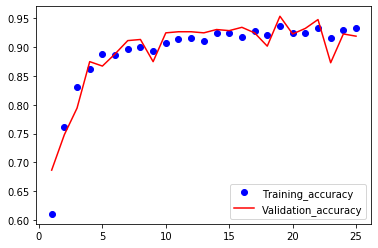

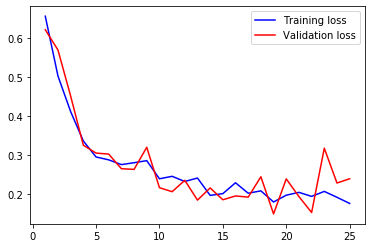

In [55]:
import matplotlib.pyplot as plt

#training set had many 'hard' cases to learn
#validation set had mostly 'easy' cases to predict
print(history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training_accuracy')
plt.plot(epochs,val_accuracy,'r',label='Validation_accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.legend()
plt.show()

In [56]:
test_gen = test_data.flow_from_directory('/opt/datasets/chest_xray/test/',target_size=(150,150),batch_size=32,class_mode='binary')

results = my_model.evaluate(test_gen)

Found 624 images belonging to 2 classes.
  ...
    to  
  ['...']
20/20 [==============================] - 3s 140ms/step - loss: 0.3692 - accuracy: 0.8574 - precision: 0.8930 - recall: 0.8769


In [15]:
# RANDOM FOREST APROACH
import glob
import numpy as np
from PIL import Image
import os
import cv2

def load_chest_xray_balanced(path):
    img_data_array = []
    filelist = glob.glob(path)
    x_labels = []
    #list(map(lambda x: 1 if os.path.split(os.path.split(x)[0])[1]=='PNEUMONIA' else 0, filelist))
    
    for file in filelist:
        
        if os.path.split(os.path.split(file)[0])[1]=='PNEUMONIA':
            x_labels.append(1)
        else:
            x_labels.append(0)
            
        image= cv2.imread( file)
        image=cv2.resize(image, (150, 150),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255
        img_data_array.append(image)
            
    return img_data_array,x_labels

In [16]:
(X,labels) = load_chest_xray_balanced('../../opt/datasets/chest_xray/small_data/balanced/train_balanced/*/*.jpeg')
X = np.array(X)
y = labels
y = np.array(y)

(X_val,val_labels) = load_chest_xray_balanced('../../opt/datasets/chest_xray/small_data/balanced/validation_balanced/*/*.jpeg')
X_val = np.array(X_val)
y_val = val_labels
y_val = np.array(y_val)

In [17]:
X = X.reshape(-1,150*150*3)
print(X.shape,y.shape)

(2160, 67500) (2160,)


In [18]:
X_val = X_val.reshape(-1,150*150*3)
print(X_val.shape,y_val.shape)

(538, 67500) (538,)


In [5]:
from sklearn.model_selection import KFold, train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.9, shuffle=True)

In [6]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators= 1000,# num of trees
    random_state=42
)

forest.fit(X_train,y_train)
forest.score(X_train,y_train)

1.0

In [7]:
forest.score(X_test,y_test)

0.9444444444444444